# Load dataset

In [1]:
labels = ['AF', 'N']

C:\Users\yunus\Anaconda3\envs\GPU_ENV\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
import os
# disable GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

dataset_folder = 'dataset/'
filenames = []
for filename in os.listdir(dataset_folder):
    if filename.find("_all") > -1 :
        filenames.append(filename)

In [3]:
filenames

['test_all.csv',
 'test_all_lms.csv',
 'test_all_nlms.csv',
 'test_all_noised.csv',
 'test_all_noised_-5db.csv',
 'test_all_rls.csv',
 'train_all.csv',
 'train_all_lms.csv',
 'train_all_nlms.csv',
 'train_all_noised.csv',
 'train_all_noised_-5db.csv',
 'train_all_rls.csv']

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [5]:
train_lms_df = pd.read_csv(dataset_folder + "train_all_lms.csv", header=None)
train_nlms_df = pd.read_csv(dataset_folder + "train_all_nlms.csv", header=None)
train_rls_df = pd.read_csv(dataset_folder + "train_all_rls.csv", header=None)
train_ori_df = pd.read_csv(dataset_folder + "train_all.csv", header=None)
train_noised_df = pd.read_csv(dataset_folder + "train_all_noised.csv", header=None)

test_lms_df = pd.read_csv(dataset_folder + "test_all_lms.csv", header=None)
test_nlms_df = pd.read_csv(dataset_folder + "test_all_nlms.csv", header=None)
test_rls_df = pd.read_csv(dataset_folder + "test_all_rls.csv", header=None)
test_ori_df = pd.read_csv(dataset_folder + "test_all.csv", header=None)
test_noised_df = pd.read_csv(dataset_folder + "test_all_noised.csv", header=None)

In [6]:
denoised = 'rls' # isi dengan 'lms', 'nlms', 'rls' untuk memilih sumber dataset dari hasil denoising tsb.
                  # isi dengan 'ori' jika ingin menggunakan original dataset
                  # isi dengan 'noised' jika ingin menggunakan noised dataset

if denoised == 'lms':
    train_df = train_lms_df
    test_df = test_lms_df
elif denoised == 'nlms':
    train_df = train_nlms_df
    test_df = test_nlms_df
elif denoised == 'rls':
    train_df = train_rls_df
    test_df = test_rls_df
elif denoised == 'ori':
    train_df = train_ori_df
    test_df = test_ori_df
elif denoised == 'noised':
    train_df = train_noised_df
    test_df = test_noised_df


## Dataset AFDB
Dataset AFDB terdiri dari 300 kolom, dimana kolom ke 300 merupakan katerori/class.

In [7]:
train_lms_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.841315,0.208993,-0.401075,-0.674432,-0.640010,-0.551361,-0.430947,-0.326886,-0.296921,-0.296099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.008886,0.785713,0.198985,-0.660673,-0.759316,-0.707744,-0.632958,-0.492613,-0.262480,-0.057392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.680934,0.492878,-0.049686,-0.632399,-0.892528,-0.851296,-0.641743,-0.387790,-0.252640,-0.112257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.473396,0.182734,-0.407389,-0.708779,-0.511152,-0.340307,-0.156781,-0.138001,-0.139342,-0.141055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.791194,0.641438,0.162732,-0.411652,-0.848441,-0.480566,-0.284033,-0.147077,-0.043376,-0.015622,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
train_lms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33060 entries, 0 to 33059
Columns: 301 entries, 0 to 300
dtypes: float64(301)
memory usage: 75.9 MB


In [9]:
test_lms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12929 entries, 0 to 12928
Columns: 301 entries, 0 to 300
dtypes: float64(301)
memory usage: 29.7 MB


## Dataset Augmentation

In [10]:
ecg_df = pd.concat([train_df, test_df])

In [11]:
ecg_df[300]=ecg_df[300].astype(int)
equilibre=ecg_df[300].value_counts()

print(equilibre)

1    23088
0    22901
Name: 300, dtype: int64


In [12]:
# sampling and resampling dataset

from sklearn.utils import resample
n_samples = 30000 
random_states = [123, 124]

dfs = []

for i in range(len(equilibre)):
    dfs.append(ecg_df[ecg_df[300]==i])
    dfs[i]=resample(dfs[i],replace=True,n_samples=n_samples,random_state=random_states[i])

ecg_df=pd.concat(dfs)

In [13]:
ecg_df[300]=ecg_df[300].astype(int)
equilibre=ecg_df[300].value_counts()

print(equilibre)

1    30000
0    30000
Name: 300, dtype: int64


## Split dataset

In [14]:
target_train = ecg_df[300]
y = to_categorical(target_train)

X = ecg_df.iloc[:,:300].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.15, random_state=42)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51000, 300), (9000, 300), (51000, 2), (9000, 2))

## Building Convolutional Neural Network

- Import Keras library

In [17]:

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras

- Buat CNN Model dengan aritektur network : 
`CONV-POOL-CONV-POOL-CONV-POOL-FC`
- CONV : 1D Convolutional Layer
- POOL : MAX Pooling Layer
- FC   : Dense Layer + Activation

In [18]:
def cnn_model(max_len):
    
    model = Sequential()
    
    model.add(Conv1D(filters=64,
                     kernel_size=5,
                     activation='relu',
                     input_shape=(max_len, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    # Fully Connected layer (FC)
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(128, 
                    activation='relu'))
    model.add(Dense(32, 
                    activation='relu'))
    model.add(Dense(2, 
                    activation='softmax'))
              
    model.summary()
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

- sekarang kita akan melakukan proses training model dengan memanfaatkan `.fit()` pada model yang kita buat diatas.
- selain itu kita gunakan juka teknik `EarlyStoping()` untuk menghentikan proses training jika terjadi divergensi pada validation data yang diakibatkan oleh overfitting. 
- pada `EarlyStoping()` kita gunakan parmeter `patience=8` yang artinya jika proses training untuk 8 epoch tidak terjadi peningkatan maka hentikan proses training.

In [19]:
def check_model(model_, x, y, x_val, y_val, epochs_, batch_size_):
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    hist = model_.fit(x, 
                      y,
                      epochs=epochs_,
                      callbacks=callbacks, 
                      batch_size=batch_size_,
                      shuffle=True,
                      validation_data=(x_val,y_val))
    model_.load_weights('best_model.h5')
    return hist 

### Train Model CNN

- Prepare training set dan test set

In [20]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

- jalankan proses training dengan `EPOCH` sebanyak 16 dan `BATCH_SIZE` sebesar 32

In [27]:
max_len = X_train.shape[1]  

EPOCHS = 16
BATCH_SIZE = 128

model = cnn_model(max_len)
history=check_model(model, X_train,y_train,X_test,y_test, EPOCHS, BATCH_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 296, 64)           384       
_________________________________________________________________
batch_normalization_4 (Batch (None, 296, 64)           256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 148, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 146, 64)           12352     
_________________________________________________________________
batch_normalization_5 (Batch (None, 146, 64)           256       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 73, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 71, 64)            12352     
__________

## Save model

In [28]:
model.save("CNN_Classification_model_%s.h5" % denoised)

# Evaluate Model

- Plot Accuracy vs Epochs
- Plot Loss vs Epochs
- Plot Confusion Matrix

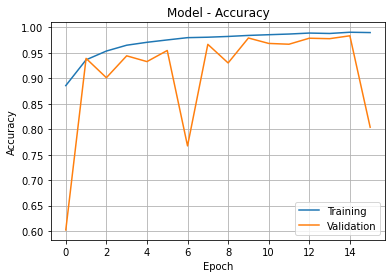

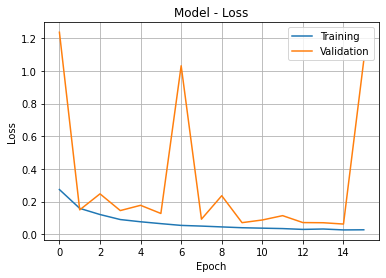

In [29]:
def evaluate_model(history, X_test, y_test):
    
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.grid()
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model - Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.grid()
    plt.show()

evaluate_model(history, X_test, y_test)    

- Dari hasil diatas kita bisa melihat jika akurasi training set = 0.99, sedangkan untuk akurasi validation set = 0.97
- Untuk plot loss training set = 0.01 sedangkan untuk loss validation set = 0.13

In [30]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5, 5))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

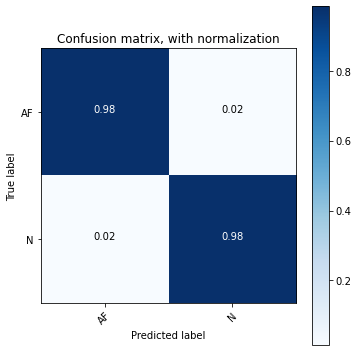

In [31]:
# predict test data
y_pred=model.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['AF', 'N'],normalize=True,
                      title='Confusion matrix, with normalization')


- dari hasil plot confusion matrix, dapat dilihat tiap kelas memiliki banyak TRUE POSITIVE predicted data
- semakin gelap kebiruan menunjukan banyaknya hasil predicted label untuk true label tersebut

In [32]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=['AF', 'N']))

              precision    recall  f1-score   support

          AF       0.98      0.98      0.98      4445
           N       0.98      0.98      0.98      4555

    accuracy                           0.98      9000
   macro avg       0.98      0.98      0.98      9000
weighted avg       0.98      0.98      0.98      9000



- Jika kita lihat, nilai report untuk seluruh klas juga bagus, 
- Nilai recall dan precission juga tinggi, menunjukan model mampu memprediksi data dengan baik untuk seluruh data pada class tersebut 